In [2]:
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import os
import json

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import base64
import io
from PIL import Image

/root/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()

openai_client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY')  
)

In [4]:
def get_gpt(messages, model='gpt-4o-mini', response_format="text", temperature=0.1):
    try:
        response = openai_client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=temperature,
            response_format={'type' : response_format},
        )
    except Exception as e:
        print(e)
        return False
    
    answer = response.choices[0].message.content.strip()
    if response_format == 'json_object':
        return json.loads(answer)
    return answer

### Datasets

In [5]:
import pandas as pd

splits = {'train': 'train.json', 'test': 'test.json'}
df = pd.read_json("hf://datasets/TableQAKit/WTQ/" + splits["train"])

In [6]:
df_test = pd.read_json("hf://datasets/TableQAKit/WTQ/" + splits["test"])

In [7]:
df_test.head()

,id,question,table_id,table,answer_text,struct_in,text_in,seq_out
0,nu-0,which country had the most cyclists finish wit...,csv/203-csv/733.csv,"{'header': ['Rank', 'Cyclist', 'Team', 'Time',...",[Italy],col : rank | cyclist | team | time | uci proto...,which country had the most cyclists finish wit...,italy
1,nu-1,how many people were murdered in 1940/41?,csv/204-csv/149.csv,"{'header': ['Description Losses', '1939/40', '...","[100,000]",col : description losses | 1939/40 | 1940/41 |...,how many people were murdered in 1940/41?,"100,000"
2,nu-2,how long did it take for the new york american...,csv/203-csv/435.csv,"{'header': ['Year', 'Division', 'League', 'Reg...",[17 years],col : year | division | league | reg. season |...,how long did it take for the new york american...,17 years
3,nu-3,alfie's birthday party aired on january 19. wh...,csv/204-csv/803.csv,"{'header': ['Series #', 'Season #', 'Title', '...","[January 26, 1995]",col : series # | season # | title | notes | or...,alfie's birthday party aired on january 19. wh...,"january 26, 1995"
4,nu-4,what is the number of 1st place finishes acros...,csv/204-csv/272.csv,"{'header': ['Date', 'Competition', 'Location',...",[17],col : date | competition | location | country ...,what is the number of 1st place finishes acros...,17


### Embeddings

In [8]:
def get_embedding(input: str):
    response = openai_client.embeddings.create(
        model="text-embedding-ada-002",
        input=input,
        encoding_format="float"
    )
    return response.data[0].embedding

In [9]:
from concurrent.futures import ProcessPoolExecutor

def process_column(column_name, column_data):
    # Combine column data into a single string and calculate embedding
    column_string = column_name + ' ' + ' '.join(column_data.apply(str).values)
    return get_embedding(column_string)

def get_column_embeddings(df):
    embeddings = {}
    with ProcessPoolExecutor() as executor:
        # Map each column in parallel and collect results
        results = executor.map(process_column, df.columns, [df[col] for col in df.columns])
    
    # Combine column names with their corresponding embeddings
    embeddings = dict(zip(df.columns, results))
    return embeddings

In [10]:
def process_row(row_data):
    row_string = ' '.join(row_data.apply(str).values)
    return get_embedding(row_string)

def get_row_embeddings(df):
    embeddings = {}
    with ProcessPoolExecutor() as executor:
        results = executor.map(process_row, [df.iloc[i] for i in range(len(df))])
    embeddings = dict(zip(range(len(df)), results))
    return embeddings

### Scoring

In [11]:
def cosine_similarity(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    dot_product = np.dot(v1, v2)
    magnitude = np.linalg.norm(v1) * np.linalg.norm(v2)
    return dot_product / magnitude if magnitude != 0 else 0

def get_table_score(df, q):
    column_embeddings = get_column_embeddings(df)  # 각 열(column)의 임베딩
    row_embeddings = get_row_embeddings(df)        # 각 행(row)의 임베딩
    q_embedding = get_embedding(q)                 # 질의(query) 임베딩
    
    scores = pd.DataFrame(0.0, index=range(len(df)), columns=df.columns, dtype=float)

    # 행(row) 점수 계산
    for i in range(len(df)):
        row_score = cosine_similarity(row_embeddings[i], q_embedding)
        scores.iloc[i, :] += row_score  # 모든 열에 동일한 row score 추가

    # 열(column) 점수 계산
    for col in df.columns:
        col_score = cosine_similarity(column_embeddings[col], q_embedding)
        scores[col] += col_score  # 열마다 개별 column score 추가

    return scores.astype(float)

### Highlighting

In [12]:
from matplotlib.colors import Normalize

def generate_table_images(original_df, score_df, cmap='YlOrBr'):
    def create_table_image(df, scores=None):
        """
        df: DataFrame to render as table
        scores: DataFrame of scores with the same shape as df
        cmap: Colormap for score-based coloring
        """
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis('tight')
        ax.axis('off')

        # Create table
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

        # Style and color settings
        table.auto_set_font_size(False)
        table.set_fontsize(10)

        # Adjust column widths based on content
        for col_idx in range(len(df.columns)):
            table.auto_set_column_width([col_idx])  # Set width based on column content

        if scores is not None:
            norm = Normalize(vmin=scores.min().min(), vmax=scores.max().max())
            if type(cmap) == str:
                try:
                    colormap = plt.colormaps[cmap]  # 최신 colormap 호출 방식
                except:
                    colormap = cmap
            else:
                colormap = cmap
            for (i, j), cell in table.get_celld().items():
                if i == 0:  # Header row
                    cell.set_facecolor('#CCCCCC')
                    cell.set_text_props(weight='bold')
                else:
                    color = colormap(norm(scores.iloc[i - 1, j]))
                    cell.set_facecolor(color)
                    cell.set_text_props(color='black')
        else:
            for (i, j), cell in table.get_celld().items():
                if i == 0:
                    cell.set_facecolor('#CCCCCC')
                    cell.set_text_props(weight='bold')

        # Save to buffer
        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
        plt.close(fig)

        # Convert to Base64
        img_buffer.seek(0)
        img_base64 = base64.b64encode(img_buffer.read()).decode('utf-8')
        img_buffer.close()
        return img_base64

    # Create images
    highlighted_table_img = create_table_image(original_df, scores=score_df)
    original_table_img = create_table_image(original_df)

    return highlighted_table_img, original_table_img


In [26]:
index = 542 # 12

table1 = df_test.iloc[index].table
table1 = pd.DataFrame(table1['rows'], columns=table1['header'])

q1 = df_test.iloc[index].question
score = get_table_score(table1, q1)

print(q1)

what year did she do same as 2007


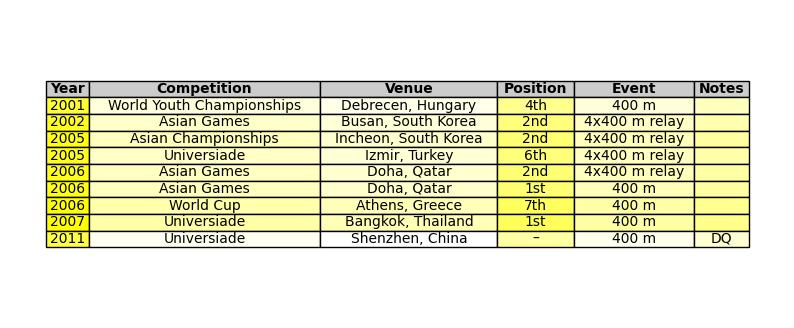

In [25]:
from IPython.display import display, Image
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_white_yellow', ['#FFFFFF', '#FFFF00'], N=256
)

highlighted_table, original_table = generate_table_images(table1, score, cmap=custom_cmap)

# Base64 문자열을 디코딩
image_data = base64.b64decode(highlighted_table)

# 디코딩된 이미지를 BytesIO 객체로 변환
image = io.BytesIO(image_data)

# Jupyter Notebook에서 이미지 표시
display(Image(data=image.read()))

### Evaluation

In [237]:
def answer_with_text(data):
    prompt = f"""
Answer the following question. Just give the answer, not the process.

Table: {data['table']}

Question: {data['question']}

Answer: 
"""
    answer = get_gpt(messages=[{'role':'user', 'content': prompt}], response_format = 'text')
    answer = answer.lower()
    return data['seq_out'] in answer

In [28]:
def answer_with_image(data):
    table = pd.DataFrame(data['table']['rows'], columns=data['table']['header'])
    score = get_table_score(table, data['question'])
    highlighted_table, original_table = generate_table_images(table, score, cmap=custom_cmap)
    
    messages1 = [{
        "role": "user",
        "content": [
            {"type": "text", "text": "Answer the following question. Just give the answer, not the process. \nTable: "},
            {
                "type": "image_url",
                "image_url": {
                    "url" : f"data:image/jpeg;base64,{original_table}",
                    "detail" : 'auto'
                }
            },
            {"type": "text", "text": f"Question: {data['question']}\nAnswer:"}
        ],
    }]

    messages2 = [{
        "role": "user",
        "content": [
            {"type": "text", "text": "Answer the following question. Just give the answer, not the process. \nTable: "},
            {
                "type": "image_url",
                "image_url": {
                    "url" : f"data:image/jpeg;base64,{highlighted_table}",
                    "detail" : 'auto'
                }
            },
            {"type": "text", "text": f"Question: {data['question']}\nAnswer:"}
        ],
    }]

    answer1 = get_gpt(messages1, response_format = 'text')
    answer1 = answer1.lower()
    answer2 = get_gpt(messages2, response_format = 'text')
    answer2 = answer2.lower()

    return data['seq_out'] in answer1, data['seq_out'] in answer2

In [ ]:
def evaluate_with_text(data, output_file='text_results.txt'):
    correct = 0
    with open(output_file, 'w') as file:
        for i in range(len(data)):
            is_correct = answer_with_text(data.iloc[i])
            if is_correct:
                correct += 1
            file.write(f'Row {i}: {is_correct}\n')
        file.write(f'Correct: {correct} ({correct / len(data)})')
    return correct / len(data)

def evaluate_with_image(data, output_file='image_results.txt'):
    correct1 = 0
    correct2 = 0
    TF = 0
    FT = 0
    with open(output_file, 'w') as file:
        for i in range(len(data)):
            result1, result2 = answer_with_image(data.iloc[i])
            correct1 += result1
            correct2 += result2
            file.write(f'Row {i}: {result1}, {result2}\n')
            if result1 and not result2:
                TF += 1
            elif not result1 and result2:
                FT += 1
        file.write(f'Non-Highlight: {correct1} ({100*correct1 / len(data)}%) Highlight: {correct2} ({100*correct2 / len(data)}%)\n')
        file.write(f'TF: {TF}, FT: {FT}')
    return correct1 / len(data), correct2 / len(data)

In [244]:
# eval with text
print(evaluate_with_text(df_test[:10]))

0.5


In [32]:
# eval with image
print(evaluate_with_image(df_test[100:105], output_file='results/image_results_100_104.txt'))

(0.6, 0.4)


In [ ]:
for i in range(100, 1000, 100):
    print(evaluate_with_image(df_test[i:i+100], output_file=f'results/image_results_{i}_{i+99}.txt'))